In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import re


# Load your dataset
df = pd.read_csv('S:\ML Course\Midterm Project 1\mobile_price.csv')

# Drop the 'Unnamed: 8' column that was showing up
if 'Unnamed: 8' in df.columns:
    df = df.drop('Unnamed: 8', axis=1)


    
len(df)


407

In [12]:
df.head()

,Brand,Model,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
0,Apple,iPhone 13 Pro,128 GB,6 GB,6.1,128,3095,999
1,Samsung,Galaxy S21 Ultra,256 GB,12 GB,6.8,256,5000,1199
2,OnePlus,9 Pro,128 GB,8 GB,6.7,128,4500,899
3,Xiaomi,Redmi Note 10 Pro,128 GB,6 GB,6.67,128,5020,279
4,Google,Pixel 6,128 GB,8 GB,6.4,128,4614,799


In [57]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
df.head()


,brand,model,storage,ram,screen_size_(inches),camera_(mp),battery_capacity_(mah),price_($)
0,apple,iphone_13_pro,128_gb,6_gb,6.1,128,3095,999
1,samsung,galaxy_s21_ultra,256_gb,12_gb,6.8,256,5000,1199
2,oneplus,9_pro,128_gb,8_gb,6.7,128,4500,899
3,xiaomi,redmi_note_10_pro,128_gb,6_gb,6.67,128,5020,279
4,google,pixel_6,128_gb,8_gb,6.4,128,4614,799


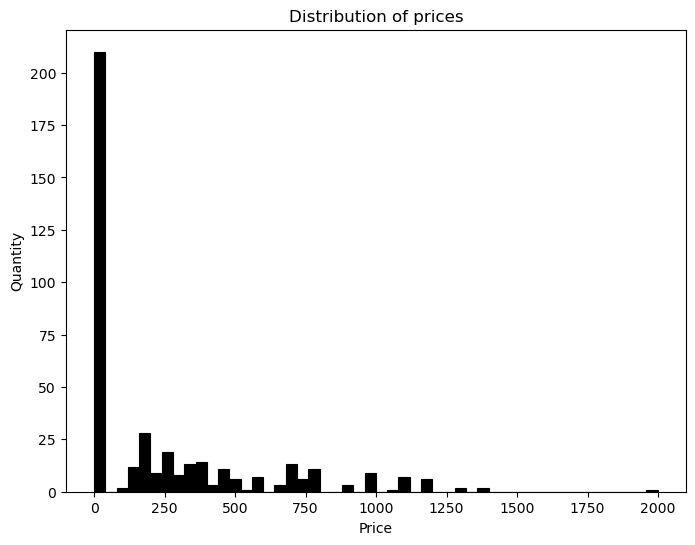

In [73]:
# Rename column price_($) to price
df.rename(columns={'price_($)': 'price'}, inplace=True)

# Convert 'price' to numeric and handle any non-numeric entries.
df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0)

# Handle NaN values that may have been introduced by non-numeric entries.
df['price'].fillna(df['price'].median(), inplace=True)

# Now you can safely log transform the price column.
df['log_price'] = np.log1p(df['price'])


plt.figure(figsize=(8, 6))

sns.histplot(df['price'], bins=50, color='black', alpha=1)
plt.ylabel('Quantity')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [62]:
df.isnull().sum()

brand                     0
model                     0
storage                   0
ram                       0
screen_size_(inches)      0
camera_(mp)               0
battery_capacity_(mah)    0
price                     0
log_price                 0
dtype: int64

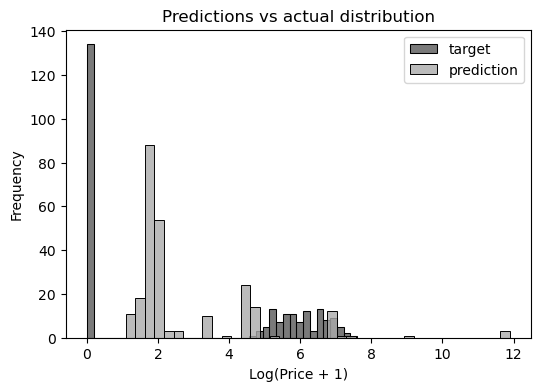

In [68]:
# Validation Framework

np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)

del df_train['price']
del df_val['price']
del df_test['price']

# Linear Regression

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Baseline Solution

base = ['storage', 'screen_size_(inches)', 'camera_(mp)']

def prepare_X(df):
    df_num = df.copy()
    for col in base:
        # Convert all columns in 'base' to numeric, coercing errors to NaN
        df_num[col] = pd.to_numeric(df_num[col], errors='coerce')
    # Fill NaN values that were created by non-numeric entries with zeros
    df_num = df_num.fillna(0)
    X = df_num[base].values
    return X

X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)

plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()
